# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [6]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from itertools import product

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [7]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


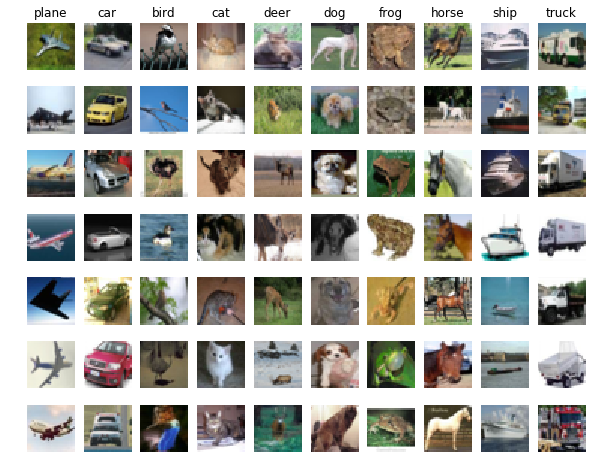

In [8]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [9]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [10]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


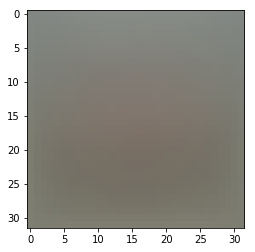

In [11]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [12]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [13]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [14]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.971633


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [15]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -20.767609 analytic: -20.767609, relative error: 9.486598e-12
numerical: 13.192716 analytic: 13.192716, relative error: 5.385266e-12
numerical: -1.359895 analytic: -1.359895, relative error: 1.261528e-10
numerical: 16.457612 analytic: 16.457612, relative error: 2.701221e-11
numerical: -24.993065 analytic: -25.019776, relative error: 5.340906e-04
numerical: -18.012173 analytic: -18.012173, relative error: 3.686408e-13
numerical: 14.384593 analytic: 14.384593, relative error: 1.815609e-11
numerical: -10.987304 analytic: -11.072229, relative error: 3.849777e-03
numerical: -2.920346 analytic: -2.899739, relative error: 3.540729e-03
numerical: 34.583812 analytic: 34.583812, relative error: 6.755370e-13
numerical: 0.188725 analytic: 0.188436, relative error: 7.656259e-04
numerical: -2.491814 analytic: -2.495184, relative error: 6.757376e-04
numerical: -8.423951 analytic: -8.421204, relative error: 1.630666e-04
numerical: -10.749439 analytic: -10.739971, relative error: 4.405836e-0

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [16]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.971633e+00 computed in 0.153126s
8.97163297598
Vectorized loss: 8.971633e+00 computed in 0.005828s
difference: 0.000000


In [17]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.152862s
8.97163297598
Vectorized loss and gradient: computed in 0.005263s
difference: 0.000000


In [18]:
test = np.array([[1,2,20],[5,9,4]])
test.argmax(axis=1)

array([2, 1])

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [19]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

783.070917155
iteration 0 / 1500: loss 783.070917
779.633106759
774.918711512
771.001659614
767.519293263
762.874402157
758.795862966
752.868891623
749.960233153
745.317097995
743.485758555
739.077230594
736.400595736
731.134968553
727.158808755
724.89097721
718.812321864
716.670080682
712.721782789
708.59903051
706.524780877
701.892356433
698.190533567
694.644480541
690.547747964
686.963659485
682.670358173
678.707082856
675.807354056
673.382737438
669.324409791
667.312189235
662.232572324
660.547145799
656.786919132
654.65131428
650.370669005
645.924461968
641.956138327
639.124125708
636.730587784
632.764162488
630.827688056
627.204961807
624.290834065
621.20599932
617.329069873
616.166301716
613.174276175
608.026978501
605.369285699
601.58884029
599.295815808
595.870906986
593.776189759
590.580977569
588.117310276
583.220797093
581.3523287
578.437531678
574.622381921
571.444889614
569.526580148
565.734044087
563.633745742
559.809337367
558.154450471
554.474374311
552.660955656
548.2

44.3201595458
44.4299112634
45.245875066
44.5630966133
44.2196943445
43.6707915519
44.1878043807
43.8316688016
43.6633452047
43.5188141754
43.9618495783
43.1549117276
42.9951548045
42.9818864865
42.8395144766
41.8253596652
iteration 600 / 1500: loss 41.825360
42.7500725227
41.9839009599
41.2256520702
41.782572752
41.7428214716
40.7343531702
40.8165003091
40.7471162244
40.3190270853
40.39380486
39.9991213525
39.5386610902
39.5595359036
39.6371746598
39.3737320502
39.5851542485
39.3493324605
38.6582725823
38.5411814823
38.7377760034
38.3190306923
38.262249426
38.167390743
37.814630935
37.6730098629
37.1718204549
38.0965936955
37.4159197276
36.9970894795
36.8711691
36.7482377853
36.6474780385
35.9484681707
35.9599779292
36.0771115963
36.2280486075
35.9637774134
35.5859498871
35.4485710628
35.2668333612
35.1717675901
35.3335590455
35.0705178503
35.0254786309
34.1971543529
34.6191232019
33.758938601
34.1373884147
33.7020922142
33.9686625641
34.3959752728
33.1222776166
33.6973952492
33.30735

7.54925832126
7.52006612352
7.63820029803
7.74581216817
7.6374272928
7.094330744
7.89709596034
7.49578071759
7.55580114045
7.58653894293
7.5633605409
6.93605560837
7.35067515378
7.16380065461
7.59771370957
7.29243524856
7.12215039817
7.63787166514
7.80701930146
6.73549480932
7.43821590588
7.31396485214
7.78991501207
7.49499501253
7.90071569568
7.49454182461
7.57808802514
7.36312358682
7.15717741326
7.22344403715
7.80885654682
7.51510801955
7.4997448788
7.40124384568
8.05793820504
7.80860406872
7.26430699688
7.50532481758
7.84659705976
6.59915225098
iteration 1200 / 1500: loss 6.599152
7.13089105913
6.66127413247
7.32559707003
6.90383335519
7.06805377186
7.43135140548
7.40847299606
7.10211383822
7.10050855174
6.66482893386
7.73598510213
6.62736613633
7.53939480324
7.17302406243
6.59127261656
7.99601191055
7.08337952096
6.85138611269
7.42067080401
7.12450445307
6.96198114183
7.95620267625
7.19108691255
6.71928115602
6.83249571049
6.53776213585
7.22830022173
7.19521539118
6.88336164805
6.

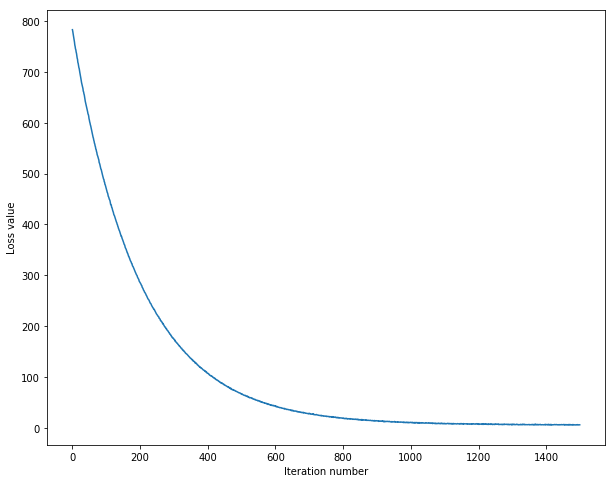

In [20]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [21]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.380061
validation accuracy: 0.383000


In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [2e-7,1e-7, 5e-8]
regularization_strengths = [2e4, 1e5 ,5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

for rate,reg in product(learning_rates,regularization_strengths):
        model_svm = LinearSVM()
        model_svm.train(X_train,y_train,learning_rate=rate,reg=reg,num_iters=1500, verbose=False)
        train_accuracy = np.mean(y_train == model_svm.predict(X_train))
        valid_accuracy = np.mean(y_val == model_svm.predict(X_val))
        if valid_accuracy > best_val:
            best_val = valid_accuracy
            best_svm = model_svm
        
        results[(rate, reg)] = (train_accuracy, valid_accuracy)




################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

641.12502689
635.807753279
628.437835477
622.898534028
619.067815834
613.186084569
608.99322574
600.62161218
596.470218505
591.479881637
586.205925256
582.501912867
577.069478411
570.999321865
568.282643393
563.515456869
556.508558262
553.269543441
550.389578931
545.283361928
539.214114832
534.406607463
530.635976751
528.133501367
521.602675021
517.920171449
514.19144409
508.97046807
505.379466618
501.868916823
496.335156365
492.424958691
488.74902075
487.104514919
481.37473615
476.3967335
473.624049902
470.108994753
464.732024843
462.671949514
458.549634133
453.969339235
450.858168317
447.664403295
442.957865578
440.071532404
437.29681278
432.67131082
429.891599893
425.860633049
422.511270599
420.308581841
416.853540439
412.268781178
408.379508136
406.685205602
401.796016116
400.028397095
395.581082182
392.556260333
389.727659793
387.026639695
384.664122856
380.307503417
377.107396034
374.880576638
371.431162729
368.973740923
366.178027076
362.650160506
359.827908572
356.69552191
354.

9.75980117954
9.59665769531
9.75478995641
9.90534985966
9.45724150973
9.81565842166
9.88772191036
10.1732872136
9.6381306125
9.53546954662
9.20764892103
8.7506493868
9.90604577595
9.67074508938
10.0538102234
9.34155712805
9.05248477173
9.13677434045
8.75175317136
9.06423159631
9.57642314751
9.27424469383
9.25847091275
9.52332284329
9.21965746398
8.92199455956
9.23136062878
9.22663328034
8.98222193155
8.94515359365
8.78088500045
8.35087577094
9.01336040099
8.56501757595
8.53522078552
9.08910669469
8.49732488416
9.33891178923
9.04800510788
8.54154108415
8.82078794441
8.57847749365
8.44859808332
8.58044574175
7.67125082776
8.35712448459
8.64809311544
8.53959993172
8.05610948848
8.72872310673
8.37279140338
8.28704631364
7.80248271416
8.29928909699
8.21695028354
8.46971883809
7.62822008013
8.12458402515
8.3653237926
8.36304818385
8.47702804892
8.02449996308
8.22451611047
8.29655835797
8.23767133461
7.99383408019
8.08470083691
7.96658940139
8.4973096012
7.86560821567
7.83787060095
7.75300261

5.71167031767
5.17098767745
5.24681833641
5.7768230931
5.4273006067
5.23854433441
5.34628756909
5.39561042847
5.84365165023
5.25874671404
4.9662912518
5.03972581465
4.74556120644
5.3240309577
4.86646234516
5.72601669802
5.23099700281
5.3995430294
5.68799205629
5.27932817676
5.29865518425
5.0379998751
5.53027876874
5.3714451151
5.17902679382
5.19961434842
5.75764411419
5.94276044684
5.02652135108
4.67410052108
5.34365582057
5.01728385058
5.6023174946
5.13981328402
5.57759750813
5.29042640843
5.42282985469
5.63538240552
5.9510405746
5.22554864738
5.50828528007
5.55789833175
6.02898446077
5.66843655829
5.01434278458
5.35335956828
5.5668269224
4.84065723017
4.86293780652
5.32733444788
5.10350828627
5.12690072128
5.26656031048
5.4668255395
5.94054011319
5.68023593723
4.92789697948
5.74250255825
5.00830299794
5.54352870622
5.82921763215
5.53957077943
5.32220846932
5.52650030366
5.37393793574
5.04195055901
5.25135928498
5.78755048094
5.45108912393
5.13076061152
5.47014331315
5.81178856201
5.8

6.7726191591
6.13947986309
5.97885442439
6.00072072924
6.18842398447
6.52177899742
6.55925566228
6.09071269252
6.43325087179
6.33933047214
6.02644051523
6.60075299898
6.22601556064
6.38034226046
6.40788745758
6.41610310167
6.30593257012
6.1988220158
6.07069086252
6.30115671792
6.57267604783
5.98048141516
6.64241940118
6.54097792288
6.32736156423
6.42271369372
5.99535805316
6.10605043864
6.41445529545
6.01359680408
5.86393653167
6.27830902498
6.57691947527
6.23133889633
6.29535582798
6.55445428575
6.13217211454
6.53103518189
6.40153963118
6.26186702351
6.36521862799
6.42150295535
6.40717654822
5.94991357525
6.37644149025
6.27242184317
6.66080355293
6.7329126827
5.98210582087
6.47468285318
6.23925282984
5.97006849577
6.04199089766
6.24849033067
6.30897569229
5.86428880656
6.34125707835
5.77905537331
6.22504522035
5.92922719856
6.86397065753
6.61886319076
5.98921979314
6.39771942179
6.13775765184
5.97530968028
6.05489677444
5.89678248692
6.57294349869
5.6986577788
6.32276039409
5.79388770

6.09804204158
6.33819167682
6.50729073817
6.94948235981
6.27335355508
6.56051851804
5.83592887421
6.25383009444
6.52486362588
6.18316001304
6.13928848012
6.49258200485
6.11511822015
6.0007889521
6.66741978452
6.56985042867
6.57813183597
6.0652743347
6.38449147778
6.2414921996
5.8300762021
5.90090038191
6.30165494226
6.0198478846
6.62862062143
6.26355628446
6.29281012019
5.95953197383
6.29263075232
6.35877114712
6.15716340223
6.50030586449
6.45376431696
5.75058243866
6.92131449478
6.35421965883
6.15817144905
5.98404310942
5.95184891068
6.19737833141
6.64210991105
6.41566932153
6.56893241405
6.1689513985
6.09009425704
6.58452040179
5.86301212119
6.40312707911
5.90021879429
6.41752415215
6.72697635783
6.38625738495
6.70656917032
6.73361528521
6.40035745836
5.87535271206
6.39035329039
6.05422159895
6.26566327112
6.01657740381
6.16161813423
5.79504541377
6.07698590805
6.48526258869
5.99112761285
6.37438406575
6.64147500786
6.63843699509
6.23353990603
6.41951591083
6.56688092212
6.5776606795

475.220244333
465.576546578
456.448266566
447.031733256
438.356879394
430.448350206
421.695212826
413.081427265
404.671879523
397.514777635
388.883648998
381.573691676
373.212129135
364.998472509
359.483570312
352.950627661
345.524103495
338.611293004
330.968577241
325.423524289
319.047899153
312.83653949
305.918016237
300.119888263
294.518641653
288.302170515
282.875602746
277.265967433
272.09073069
266.649864685
261.68566021
255.786343539
251.058830291
246.07673242
241.530834869
235.986347489
232.349023956
226.980480941
223.301293679
218.481824498
214.311362426
210.032340022
205.3477812
201.622525544
197.220356499
194.377061052
190.095625451
186.798848539
182.558020156
179.038119771
175.975968123
172.639708274
169.086850194
165.624973114
163.225888064
159.521442717
156.651336506
153.317688208
150.433653348
148.278984365
145.421019112
142.080585048
139.011385937
136.377526793
134.102649296
131.485415649
129.199086253
126.67312136
124.93532884
121.32444085
119.045174544
117.178974206
1

5.76198890593
5.6267473602
5.48991453177
5.80588323844
5.43533111837
6.04056581021
6.076909126
5.71561402062
5.55602511852
5.87828987313
5.85791520454
5.87345723139
6.23626288654
5.85239112091
5.7051446831
5.8701302501
5.67991781662
5.63358487608
6.36619802578
5.53758531809
5.73589214498
5.6948047917
6.00375639375
6.14623753621
6.4949849542
5.89312449002
6.15616686037
5.84110599005
5.55906074468
5.98343333549
5.73420468732
6.25655095146
5.38124956001
5.58641597208
6.36390877686
5.75498703212
5.72001965007
6.22078410062
5.99135180091
5.52478394605
5.65673222586
6.19417965424
5.84826724583
6.36588807953
5.39295935246
5.52877391438
6.31849746437
5.66995793287
5.83051799017
5.86147801149
5.98844785929
5.9431444751
6.15652957511
6.2042105426
5.87004605322
6.30736389788
5.99561438447
5.92909079764
5.51314051671
5.83445624511
5.92783258049
5.8535371717
5.92853166086
6.11773777874
5.79268977479
5.40445319154
5.73580266003
5.80400580881
5.14615520802
5.47001637482
5.86184356198
6.0251949882
6.2

6.08286323326
5.75779497427
6.18492324787
5.98492186073
5.30730438344
6.34591404752
5.65453597752
5.86909620555
5.69097715899
5.60314670538
6.26058030849
6.40517611344
6.30533459465
5.92763370827
5.8419504185
5.936230846
5.77185137949
5.4043721947
5.80252300091
6.20287589128
5.69109517623
5.18887740844
5.82295716919
5.42783749508
5.66880874823
6.20064021226
5.91469098889
5.77958669305
6.08597130012
5.22295900286
5.72574224415
6.65082741847
6.66677464538
5.93577890267
5.95485264079
5.66097254169
5.68316489106
6.32010936372
5.79327804996
5.598458907
5.9738468773
6.14040231641
5.61154259266
5.85192335343
5.39231884262
5.9541203868
6.17101453525
5.64752717574
6.03973214353
6.60769999223
5.8477004028
5.80764655215
5.88547733318
5.71395910129
5.6093413395
6.18402714032
6.44141133682
6.0582669001
6.22322632627
5.49408903361
6.20463213046
5.17227928939
5.98793548498
6.18348161461
6.10891724192
6.21176064951
5.3488616719
6.22086588179
5.83537282436
6.52336315777
5.74753047016
5.78698830435
6.19

132.716840699
131.89028794
131.61517565
132.078668105
131.316558768
130.381395324
129.931341667
129.539813834
127.855870015
128.294431715
127.693915651
127.231212196
127.260458453
126.732014707
125.306959275
125.872712907
125.129745797
123.514745315
123.114080733
123.630999121
122.655860679
122.200341125
121.252272496
121.528531255
120.638174536
120.988579966
119.659103341
120.151652371
119.268535222
118.639054581
118.362539773
117.240684425
118.068436752
116.564315926
117.688927508
116.51070551
115.912703711
114.948248803
114.924001228
114.718955655
113.966253721
114.103981465
112.679059196
112.39962305
111.856979329
111.10541649
110.961955261
111.23842554
110.168466742
109.467290491
109.211578857
108.711335767
108.689200167
108.425791613
107.349574534
107.101303154
106.924516922
106.46164539
106.341805747
106.01762365
105.279914222
104.753942355
104.989534194
104.156084432
103.424181793
103.291398924
102.7112935
102.071465987
102.002393464
101.492267132
101.686474396
101.557079156
10

15.0252372017
14.6864599616
15.0428968488
14.9795036285
15.6501725821
15.367341406
14.8738355017
14.5525603635
15.2232760858
15.2889009964
14.9022584565
14.572864597
14.7595815356
14.9375520624
14.7803035995
14.5997228784
15.134103595
14.8446903358
14.2988336622
14.8521241447
14.6723072801
14.3651170784
14.3756938044
14.3838098032
14.7846156241
14.0743462265
13.8258769315
13.7346449445
14.1570536823
13.6095464028
14.0686748618
13.8154343794
14.284549791
13.9186731035
14.3655486876
13.6686875211
13.9958254436
13.9203957826
14.4334705225
13.6591827218
13.5890579909
13.5440901114
13.486831708
13.7114860285
13.7617590277
13.5809044435
14.0129469147
13.6045636484
13.7090385779
13.3430287698
13.4084825117
13.2474208969
12.9579090632
13.7741075071
13.3148611805
12.5023649819
13.8361074206
12.936432142
13.2386687734
13.4907101833
12.5284708694
12.9979336081
12.7782438926
12.4052552895
12.7295933175
12.7978614775
12.8910433418
12.7626442808
13.1454846043
12.7484439627
12.8877248682
12.884388851

290.987316309
285.298507244
279.799857853
274.314012696
269.082728517
263.578947371
258.616139813
252.714723486
248.176396437
243.804953429
238.331467323
233.611738493
229.320597656
224.780849505
220.342830699
216.402530541
212.298215541
208.427562083
203.939726113
200.689850761
196.314211801
192.897504006
188.845957695
185.545052463
182.001815892
177.562952645
175.316017079
171.26905232
167.856551327
164.927717179
161.557698304
158.144075469
156.0233434
152.386147356
149.469887256
146.867957149
143.701571337
140.678412515
137.721836116
135.678532854
133.332938924
130.601645596
128.06297298
125.395033597
122.813515754
121.078040926
118.779000463
116.370328849
114.15347786
112.204056075
109.661898351
107.505385992
106.046981141
103.441901515
101.541068633
99.947284038
98.4384235726
96.2862718133
94.8204834921
92.873429473
91.1314062731
89.365446149
87.8222129446
85.6181453076
84.1427963191
82.3095950537
81.3227919894
79.441855388
78.8131864127
76.1995782203
75.3053288575
73.545685656
72

6.41616589331
6.41669632887
6.38223846547
6.80319089246
6.24386958749
6.43064830696
5.86202765227
6.79241933613
6.32641137615
6.05940871468
6.54683165229
5.99247595355
5.73628800367
6.25476827973
5.9520891125
6.07852742888
6.12743551033
6.09814634835
6.2608643603
6.45755220619
5.83926055075
6.12210226388
6.19640096814
6.36098966859
6.18402546833
6.23587573647
6.10392938087
6.02296790895
6.2881460257
6.16634262137
6.27315602491
6.42268379928
6.29859708987
6.0668800659
5.7868081097
5.97583684014
6.12465750538
6.43135361359
6.88890872174
6.40985959824
6.02417251788
6.62887214786
5.90548179034
6.34426720906
6.16064486337
6.51088143626
6.27517539081
6.37683392072
6.35652849048
6.23921088867
6.39278472879
6.64219688773
6.01956524666
6.39055735316
5.99657201256
5.7836617517
6.33044196442
6.860573984
6.13624982782
6.28713979615
6.45127117091
6.37687287917
5.97857445737
6.21620857644
5.55171015766
6.43493387535
6.26955804889
6.3138644995
6.74591314925
5.75683452138
6.28024199919
6.12042578284
6

6.4560135814
5.71778146624
6.29580604073
5.94170013862
6.69919167312
5.67697388291
6.3724486388
5.94392937256
6.32733817167
6.1877797509
6.78620032616
5.56184718021
6.61884676508
6.32215243702
6.07089568687
5.93543428903
6.22877999327
6.73291397952
6.3655404345
5.96946544501
6.54609907371
5.95142486342
6.09333736723
6.31723803295
6.11997119391
5.49645279314
6.39730350741
5.73808548097
6.07309855863
6.44431279415
6.28118339099
6.27392228335
5.9758118026
5.89634978623
5.77642470687
6.30306978862
6.4715477915
6.20295642884
6.14613993286
6.25813969923
6.14700483719
6.29780973101
5.98868053816
6.11333140737
6.20341153331
6.10124709846
6.15633074505
5.88917072418
5.99024522782
6.29460877486
6.06769634101
5.95686098932
5.92644103862
6.5359594858
6.33759928918
5.89979730879
6.26521859588
6.55243301193
6.17373945483
6.00364960382
6.22468229728
5.67555896502
6.48258106053
6.32516854979
6.59493262359
6.25115716014
6.38658363449
6.23551175969
6.20964426226
6.20818150944
6.23480837836
6.45518063121

26.1666323818
26.047088955
25.6081140281
25.5178897175
25.7173863369
25.0907175257
24.6512428604
25.2412067021
24.647472031
24.5306270269
23.511047711
24.172732062
23.9767028539
23.7346282946
23.9054442176
23.174345155
23.0901388843
23.1345997804
22.4825368507
22.4506273864
22.4363336805
22.5688753646
21.4100366163
22.0088885753
22.2906128267
21.474856476
21.8454574293
21.7217565706
21.0018629535
20.9616272333
20.4633395668
20.3414086655
20.6991803838
20.2966155337
19.8564754143
20.1216160745
20.1904731274
19.6025273624
20.1272515011
19.2484996678
19.8425254271
19.475689624
19.1463507304
19.2590423999
18.5521778664
18.6606064413
18.7121046873
18.5372152511
18.8039914073
18.5091409831
17.9723924351
17.6178782649
17.7695577332
18.0201292385
17.531597711
17.6312078922
17.6092496582
16.8513595933
17.004911662
17.1024425242
16.8406520777
17.2540953831
16.2963914842
16.6977942117
16.2174186368
16.2493835833
16.6819215539
15.7498667939
15.8755630762
15.9182532498
15.8954791748
15.9037854124
1

5.61661196309
6.08898535239
5.77576464995
5.7651446865
5.92819496968
5.46929668877
5.99991454557
6.37194491749
5.35766895975
5.54288225683
5.614126414
5.98595473859
5.95095941233
6.2595273981
5.86730204007
5.64240263053
5.31648435009
5.53116730688
5.20107323663
5.60721790111
5.62651363692
5.69470556327
5.82458857224
6.01483098551
5.88722713706
5.44369154604
5.2739868334
5.62100071173
5.94650196111
5.73304737448
6.53327918187
6.08556070123
5.4051458281
5.82730533138
5.05894268009
5.92555364134
5.26452857051
5.93996911163
5.94903165544
5.97897141601
5.50373495996
6.18561487542
5.2638868872
6.2858226677
5.35231671133
5.50402993906
5.73450091462
5.93329366205
5.89887988183
5.86461113466
5.92538539407
5.76364637277
6.1236513329
6.30194741669
5.61729254213
5.41147964321
5.60987456591
6.2052183882
5.54422626602
5.66692831839
5.70937253686
5.51011651206
5.86804818699
5.83197241096
6.00123522924
5.74617919778
5.65647454576
5.64236360184
5.73926064062
5.48534181186
5.43872217627
6.18236009445
4.

442.35883615
439.752209338
440.951163927
439.197864601
437.679110589
437.810630977
435.885351431
435.350498632
434.488503327
434.084543784
432.699480632
432.304222887
431.268874859
430.474863343
429.052141158
429.63122063
428.034391457
427.083202908
424.674785866
424.121860179
425.289912938
423.827967702
423.660264726
420.846944767
420.71327468
420.616110519
419.733186348
417.907003785
417.46540861
415.78858975
415.339292086
414.602425274
413.91094338
411.97959385
412.02465248
412.540765036
411.752485288
410.246491168
408.671328701
408.577242325
406.931642699
405.81942036
407.38544709
405.361054293
403.765284371
404.562242181
402.528156229
400.530789574
400.502952342
400.115980731
399.097373081
397.981228424
398.435571036
398.097290383
396.920265098
395.526672988
394.731232539
394.193028308
391.57070529
392.082404516
391.384596087
390.792967617
390.435262024
389.889981578
388.55177971
387.285873351
387.259286167
386.633026125
383.926195302
384.841040968
385.194469725
382.224876411
381.

126.814075897
126.606948836
126.197637697
126.583014284
125.602567486
126.110684074
126.165573972
125.553821491
126.162802798
125.296582042
125.564854509
124.366718368
123.79914813
124.129772961
123.459616925
123.903759053
123.372663811
123.073176662
122.762953829
123.115088912
122.448083011
121.937594293
121.655386125
121.80347453
120.87698798
121.688531411
121.008813823
120.963487547
120.997438675
119.728869248
120.056489044
119.413646707
119.072961229
118.500094718
119.2513164
118.459023849
118.416345533
119.005760316
117.606846735
117.38784002
116.828252665
117.847754847
117.026927498
117.768008214
116.928368793
116.870282867
116.510864156
115.488064399
115.567550659
116.035087584
115.20201486
115.641104999
114.884260467
115.031417881
115.233154739
114.06369944
113.201634073
114.357231
114.069716734
113.592344373
113.272378672
112.829273014
112.246754624
112.14969407
111.869239887
113.186756051
111.691361786
111.563452
111.010312392
111.922492445
111.215614933
111.50292844
110.8141

40.3068392714
40.9429980325
40.0177210844
40.2568082413
39.5575184353
39.9696373808
40.0691647359
39.5659642386
40.3046428262
39.9949673424
39.7860937315
39.1295004157
39.3442013999
39.6311274978
40.1954294553
39.9710478569
39.263483455
39.1633643239
39.057976146
39.1273099728
39.0990035048
38.5841054677
38.6432323688
39.1711597482
38.5804010026
38.9888719211
38.6636903398
38.0106888212
37.9903885485
38.5478261846
38.4762946824
38.4189720886
38.1215404347
38.2612352214
38.6511329716
38.3206240519
38.3296180386
38.14741831
38.2869240998
37.3996711664
37.4119531662
37.3401366465
37.7488663092
38.0190114173
36.9591640754
37.1512680737
37.7194627494
37.4689945362
36.8583709812
37.1169432761
37.0279166885
37.0486204402
37.0817570397
37.250841487
36.7544169434
36.7658641925
37.197579258
35.9176409738
36.3887890418
36.6213382391
36.2311648206
36.2012405076
36.5178514565
35.7215763777
36.1700437246
35.766156798
35.2952203093
35.3966519446
36.083340342
35.4854819111
35.6259591292
35.5508585638


23.1896135983
22.7823780546
21.7766920845
22.4028559065
22.1647969409
21.7789009997
21.6778247801
21.5965202122
20.9145974395
21.4707251742
21.6035158692
21.0783882685
21.2345667144
20.7834270415
21.0957659568
20.6646676812
19.9210611486
20.1286806894
20.0230768507
19.9719704605
19.8729203596
19.8719611857
19.5946407571
19.2481884673
19.3150979117
18.900061486
19.0847704341
19.1082991351
19.0455321976
18.4048167516
18.3330333234
18.1259681108
18.5718388925
18.0193802619
17.921576588
17.7976650603
17.6145747672
18.1605884192
17.4174141211
17.0474093496
17.8156450085
16.801819855
16.5811520311
16.9025977788
16.9992886873
16.8609957589
16.8803641502
16.527348449
16.8194560181
16.5602738134
16.7554973982
16.4903827209
16.0607113951
15.7870081396
15.7562272679
15.7378789774
15.6730169809
15.8346347556
15.5448761205
15.500621439
15.0819245101
15.0836936353
15.166296722
14.9176995644
14.5198659727
14.9448070193
14.746552733
14.373244457
14.794775848
13.9053621623
15.0689475059
14.2464808376
1

5.5875314379
5.86728693541
6.36110637191
6.74915888951
6.85127737719
6.33302592062
6.17232387642
6.19396670682
5.89262963046
6.4430867121
6.16641601325
6.2289717089
5.88027503614
6.33118821643
6.08987555079
6.23571570009
6.55683846944
6.12060110156
6.74309913381
5.9555078731
6.24079097266
5.77645936842
6.1550323209
6.49223976184
6.06579268603
6.14374366194
6.07181878395
6.31307278113
6.09667134928
6.36311719276
5.64572155531
6.04158843711
6.68332436893
5.95839513129
6.27785918683
6.65561846684
6.43433534223
5.98746268826
6.35617604793
6.0362059561
6.53359828676
5.73778455999
6.29828093692
6.39236450933
6.12449072492
6.54941691737
6.11002212399
5.72423906751
5.78704513983
6.10991454794
6.38218826615
6.18258854551
5.64631215903
6.41165842798
5.82935716596
5.80643886203
6.19698902671
5.65488205785
6.1832355978
6.261366486
6.16284659208
6.3865724102
6.36869206903
5.80844158508
6.09164920606
5.89885221104
6.13258770173
6.37239381373
6.28637932012
6.20515770618
6.23871680344
6.37290169071
6.

520.316608172
517.007789278
516.595687479
512.664197677
509.610214571
507.581731225
504.397723619
502.750814401
499.988209268
497.321540241
495.523494562
492.364955818
490.511688058
487.17318331
484.590725124
482.531564562
479.829493223
477.415308816
475.007132303
472.652184887
471.411863761
468.623988762
465.754680951
463.866446842
461.509452074
459.907085103
456.463182988
454.728759422
451.98965051
450.160652004
447.493261727
445.56743281
443.39889803
441.044095078
439.292803525
436.718040475
435.90298757
432.564353023
430.833212578
428.564468324
425.743948563
425.038643165
422.164633868
420.324828701
417.768092926
415.942115796
413.649550144
411.833564268
409.626305805
408.166686447
405.179486299
404.031789404
402.422943852
398.946792851
397.418420356
395.047986085
393.472323751
391.069559898
389.37312805
387.664529027
385.63951362
383.816176424
381.452852361
380.465732477
378.276447185
376.312246101
373.725511729
373.140803641
370.810457841
367.902965938
367.277098668
365.173800418

30.4519628749
30.7799277366
29.7583557427
30.3464898269
30.2140150563
29.6774174553
29.3566218599
29.5067758788
29.0941583113
29.0326529016
29.3223316529
29.297626235
28.8195114829
28.4824257761
28.5312256853
28.1086520918
28.6607069128
28.1819438678
28.4360193755
27.8605533665
27.7233638665
27.7426479745
27.4399443192
27.5089473857
27.667472727
27.8086235575
27.3611340758
26.8635874125
27.1448461709
26.7394892672
26.6036664648
26.9278265794
26.5575088701
27.0737329356
26.8810999066
26.4092541232
26.2296229562
26.1385954382
25.9597480097
25.9194278168
25.7326583593
25.0681851349
25.4905007364
25.8151313271
25.1820703435
25.9465692775
24.6211984888
24.8994279664
25.2929114837
24.7478145244
24.8422847346
25.2069257413
24.2672737017
24.5869594712
24.5721266695
24.3089381012
24.6101340619
24.1376368234
23.9546207425
24.3114314564
24.4274468472
23.7705994238
23.5639666807
23.8458927249
23.6268916614
23.4802596223
23.5446519421
22.7039302825
23.4664850217
22.6761462476
23.1329581835
23.22912

6.7383707709
6.53538366996
7.0948859792
6.66196621407
7.05432112984
6.26282741064
6.18176437478
6.79919883091
6.24052406171
6.77627337864
7.25310498956
6.04333366865
7.26727091993
6.47495437588
6.73905711452
6.52384167619
6.99169582651
6.40495724986
6.83753406293
6.14988734643
6.27194953922
6.79969710446
6.40661939582
6.76332066481
6.52786181889
6.5101078365
6.65404589226
6.09242816424
5.92094459824
7.01367890364
lr 5.000000e-08 reg 2.000000e+04 train accuracy: 0.357143 val accuracy: 0.358000
lr 5.000000e-08 reg 5.000000e+04 train accuracy: 0.372755 val accuracy: 0.375000
lr 5.000000e-08 reg 1.000000e+05 train accuracy: 0.356347 val accuracy: 0.366000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.378408 val accuracy: 0.396000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.366714 val accuracy: 0.364000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.352184 val accuracy: 0.376000
lr 2.000000e-07 reg 2.000000e+04 train accuracy: 0.377082 val accuracy: 0.385000
lr 2.000000e-07 

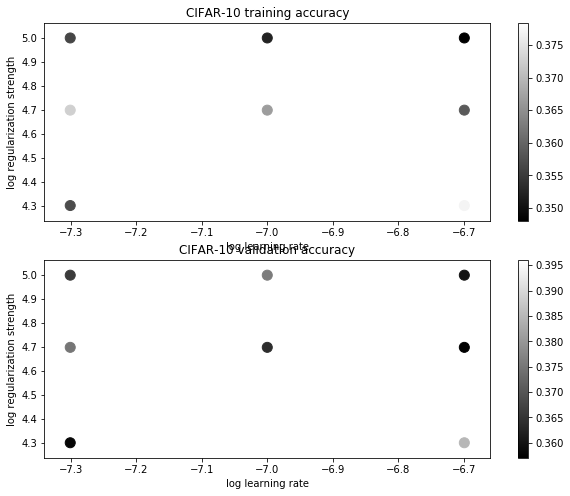

In [23]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [25]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.371000


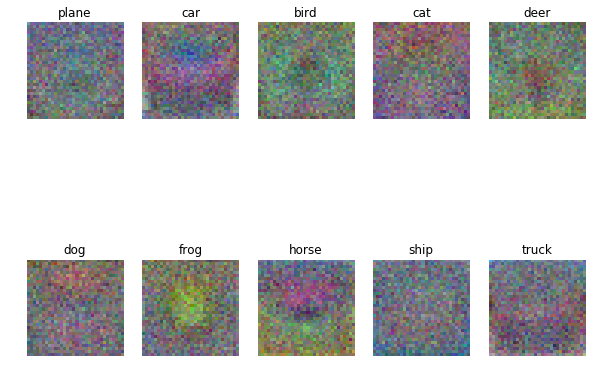

In [26]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*